<a href="https://colab.research.google.com/github/Ocalak/AFEM24/blob/main/tt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.0 MB/s eta 0:00:00


In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

import optuna
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization,LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model, Input,regularizers
import statistics




os.listdir('/content/')
file_path = '/content/pythondf.csv'
dfload = pd.read_csv(file_path)









#def median_absolute_error(y_true, y_pred):
 #   error= tfp.stats.percentile(abs(y_true-y_pred), q=50.)
  #  return error



dfload = dfload.drop(dfload.columns[0], axis=1)
# Define a function to add '00:00:00' if time component is missing
def add_missing_time_component(date_str):
    if len(date_str) == 10:  # Assuming 'YYYY-MM-DD' format
        return date_str + ' 00:00:00'
    return date_str

# Apply the function to the DateTime column
dfload['DateTime'] = dfload['DateTime'].apply(add_missing_time_component)

# Now convert the DateTime column to datetime format
dfload['DateTime'] = pd.to_datetime(dfload['DateTime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')


# Convert the datetime column to datetime objects
dfload['DateTime'] = pd.to_datetime(dfload['DateTime'])

# Extract hour of the day, day of the week, and month of the year
dfload['hour'] = dfload['DateTime'].dt.hour
dfload['day_of_week'] = dfload['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
dfload['month'] = dfload['DateTime'].dt.month

# Convert these variables to dummy variables
#df_hour_dummies = pd.get_dummies(dfload['hour'], prefix='hour').astype(int)
#df_day_dummies = pd.get_dummies(dfload['day_of_week'], prefix='day_of_week').astype(int)
#df_month_dummies = pd.get_dummies(dfload['month'], prefix='month').astype(int)



# Generate lagged features for temperature
for lag in [198,336,504]:
    dfload[f'load_lag_{lag}'] = dfload['Load_DA'].shift(lag)

dfload["Rolling_Avg_15"] = dfload["Load_DA"].rolling(window=15*24).mean().shift(7*24)
dfload["Rolling_Std_15"] = dfload["Load_DA"].rolling(window=15*24).std().shift(7*24)
dfload["Rolling_Sum_15"] = dfload["Load_DA"].rolling(window=15*24).sum().shift(7*24)
dfload["Rolling_Avg_30"] = dfload["Load_DA"].rolling(window=30*24).mean().shift(7*24)
dfload["Rolling_Sum_30"] = dfload["Load_DA"].rolling(window=30*24).sum().shift(7*24)
# Calculate the moving standard deviation over the last 30 days, excluding the first 7 days
dfload["Rolling_Std_30"] = dfload["Load_DA"].rolling(window=30*24).std().shift(7*24)

for lag in range(1, 4):
    dfload[f'temp_lag_{lag}'] = dfload['temp_actual'].shift(lag)

# Generate rolling mean features for temperature
for window in [6,24]:
    dfload[f'temp_mean_{window}'] = dfload['temp_actual'].rolling(window=window).mean()

# Generate min and max features for temperature over the last 24 hours
 ##temp_min_24 =  dfload['temp_actual'].rolling(window=24).min()

 #dfload['temp_max_24'] =  dfload['temp_actual'].rolling(window=24).max()

# Generate lag features for temperature at 24, 48, and 96 hours
for lag in [24, 48]:
     dfload[f'temp_lag_{lag}'] =  dfload['temp_actual'].shift(lag)

# Generate lag features for wind speed
#for lag in range(1, 8):
 #    dfload[f'wspd_lag_{lag}'] =  dfload['wspd_actual'].shift(lag)

#for lag in range(1, 8):
 #   dfload[f'dwpt_lag_{lag}'] = dfload['dwpt_actual'].shift(lag)

#for lag in range(1, 8):
  #dfload[f'pres_lag_{lag}'] = dfload['pres_actual'].shift(lag)

#for window in [2,4,8,12,24]:
 #   dfload[f'dew_mean_{window}'] = dfload['dwpt_actual'].rolling(window=window).mean()
# Generate min and max features for temperature over the last 24 hours
dfload['temp_min'] =  dfload['temp_actual'].rolling(window=24).min()
dfload['temp_max'] =  dfload['temp_actual'].rolling(window=24).max()


# Assuming df is your DataFrame with relevant columns

# Wind Chill calculation
#def calculate_wind_chill(temp, wind_speed):
 #   # Only calculate wind chill if temperature < 10°C and wind speed > 4.8 km/h
  #  wind_chill = np.where(
   #     (temp < 10) & (wind_speed > 4.8),
    #    13.12 + 0.6215 * temp - 11.37 * (wind_speed ** 0.16) + 0.3965 * temp * (wind_speed ** 0.16),
     #   temp
    #)
    #return wind_chill

# Humidity calculation
#def calculate_humidity(temp, dew_point):
 #   humidity = 100 * (np.exp((17.625 * dew_point) / (dew_point + 243.04)) /
  #                    np.exp((17.625 * temp) / (temp + 243.04)))
   # return humidity

# Apply the calculations to the DataFrame
#dfload['Wind_Chill'] = calculate_wind_chill(dfload['temp_actual'], dfload['wspd_actual'])
#dfload['Humidity'] = calculate_humidity(dfload['temp_actual'], dfload['dwpt_actual'])


#for lag in range(1, 6):
   # dfload[f'Wind_Chill_L{lag}'] = dfload['Wind_Chill'].shift(lag)
 #   dfload[f'Humidity_L{lag}'] = dfload['Humidity'].shift(lag)

#for window in [4,8,12,24]:
    #dfload[f'Wind_Chill_M{window}'] = dfload['Wind_Chill'].rolling(window=window).mean()
   # dfload[f'Humidity_M{window}'] = dfload['Humidity'].rolling(window=window).mean()

#Example: "Climate Change and Energy Demand in France" by Hallegatte et al., which discusses the impact of temperature on energy demand and uses 18°C as a reference for HDD.
T_base = 18

# Calculate HDD and CDD
dfload['HDD'] = dfload['temp_actual'].apply(lambda x: max(0, T_base - x))

dfload['CDD'] = dfload['temp_actual'].apply(lambda x: max(0, x - T_base))
#for lag in range(1, 8):
    #dfload[f'HDD_L{lag}'] = dfload['HDD'].shift(lag)
   # dfload[f'CDD_L{lag}'] = dfload['CDD'].shift(lag)
#for window in [4,6,8,12,24]:
 #   dfload[f'HDD_M{window}'] = dfload['HDD'].rolling(window=window).mean()
  #  dfload[f'CDD_M{window}'] = dfload['CDD'].rolling(window=window).mean()

#dfload['dwpt_min'] =  dfload['dwpt_actual'].rolling(window=24).min()
#dfload['dwpt_max'] =  dfload['dwpt_actual'].rolling(window=24).max()
#dfload['pres_min'] =  dfload['pres_actual'].rolling(window=24).min()
#dfload['pres_max'] =  dfload['pres_actual'].rolling(window=24).max()
#fload['wspd_min'] =  dfload['wspd_actual'].rolling(window=24).min()
#dfload['wspd_max'] =  dfload['wspd_actual'].rolling(window=24).max()
#dfload['HDD_min'] =  dfload['HDD'].rolling(window=24).min()
#dfload['HDD_max'] =  dfload['HDD'].rolling(window=24).max()
#dfload['CDD_min'] =  dfload['CDD'].rolling(window=24).min()
#dfload['CDD_max'] =  dfload['CDD'].rolling(window=24).max()
#dfload['Wind_Chill_min'] =  dfload['Wind_Chill'].rolling(window=24).min()
#dfload['Wind_Chill_max'] =  dfload['Wind_Chill'].rolling(window=24).max()
#dfload['Humidity_min'] =  dfload['Humidity'].rolling(window=24).min()
#dfload['Humidity_max'] =  dfload['Humidity'].rolling(window=24).max()

# Combine original DataFrame with dummy variables
#f_combined = pd.concat([dfload, df_hour_dummies, df_day_dummies, df_month_dummies], axis=1)
#f_combined = pd.concat([dfload, df_day_dummies, df_month_dummies], axis=1)
#dfload['hourdm'] =pd.get_dummies(dfload['hour'], prefix='hour').astype(int)
#f_combined = pd.concat([dfload, df_day_dummies, df_month_dummies], axis=1)
dfx = pd.concat([dfload.drop(columns=['dwpt_actual','wspd_actual','pres_actual'])], axis=1)
#dfx = pd.concat([f_combined.drop(columns=['month','day_of_week','wspd_actual'])], axis=1)

window = slice(8785, 43825)


train_val_set = dfx[window]

test_set = dfx[43825:]
features = train_val_set.drop(columns=['DateTime',	'Load_DA',	'Load_Act'])
target = train_val_set['Load_DA'].values


# Normalize the features
#scaler = StandardScaler()
#features_scaled = scaler.fit_transform(features)
#target_scaled= scaler.fit_transform(target.reshape(-1, 1))

# Prepare the data for the model
#X = features_scaled
#y = target_scaled

# Reshape the target variable to have the shape (number of samples, 168)
#y_reshaped = np.array([y[i:i+168] for i in range(len(y) - 168)])

# Adjust the input features accordingly
#X = X[:-168]

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y_reshaped, test_size=0.25, random_state=42)
#gpus = tf.config.experimental.list_physical_devices('GPU')
#if gpus:
 #   try:
  #      for gpu in gpus:
   #         tf.config.experimental.set_memory_growth(gpu, True)
    #except RuntimeError as e:
     #   print(e)
#dfx.dropna(inplace=True)
#Drop dropout
#http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43442.pdf
def create_model(trial, input_dim):
    inputs = Input(shape=(input_dim))#tf.keras.layers.Input(shape=input_dim)
    norm = inputs#BatchNormalization()(inputs)
    ll = norm
    dropout = trial.suggest_categorical('dropout',[True, False])
    if dropout:
      rate = trial.suggest_float('dropout_rate', 0, 1)
      drop = layers.Dropout(rate)(norm)
      ll = drop

    regularize_h1_activation = trial.suggest_categorical(
            'regularize_h1_activation', [True, False])
    regularize_h1_kernel = trial.suggest_categorical(
            'regularize_h1_kernel', [True, False])
    h1_activation_rate = (0.0 if not regularize_h1_activation
                              else trial.suggest_float('h1_activation_rate_l1', 1e-5, 1e1, log=True))
    h1_kernel_rate = (0.0 if not regularize_h1_kernel
                          else trial.suggest_float('h1_kernel_rate_l1', 1e-5, 1e1, log=True))
     # first hidden layer
    hidden_layer1 = layers.Dense(trial.suggest_int('neurons_1', 16, 256, log=False),
                                    activation=trial.suggest_categorical(
                                        'activation_1',['elu','relu', 'tanh', 'softmax', 'sigmoid', 'softplus']),
                                    kernel_regularizer=regularizers.L1(
                                        h1_kernel_rate),
                                    activity_regularizer=regularizers.L1(h1_activation_rate))(ll)

    regularize_h2_activation = trial.suggest_categorical(
            'regularize_h2_activation', [True, False])
    regularize_h2_kernel = trial.suggest_categorical(
            'regularize_h2_kernel', [True, False])
    h2_activation_rate = (0.0 if not regularize_h2_activation
                              else trial.suggest_float('h2_activation_rate_l1', 1e-5, 1e1, log=True))
    h2_kernel_rate = (0.0 if not regularize_h2_kernel
                          else trial.suggest_float('h2_kernel_rate_l1', 1e-5, 1e1, log=True))
  # Second hidden layer
    hidden_layer1 = LayerNormalization()(hidden_layer1)
    hidden_layer2 = layers.Dense(trial.suggest_int('neurons_2', 16, 256, log=False),
                                    activation=trial.suggest_categorical(
                                        'activation_2',['elu','relu', 'tanh', 'softmax', 'sigmoid', 'softplus']),
                                    kernel_regularizer=regularizers.L1(
                                        h2_kernel_rate),
                                    activity_regularizer=regularizers.L1(h2_activation_rate))(hidden_layer1)

    # Output layer
    hidden_layer2 = LayerNormalization()(hidden_layer2)
    outputs = layers.Dense(192,activation='linear')(hidden_layer2)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs)

    # Learning rate for the optimizer#1e-5,
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)

    # Compile the model
    optimizer =  tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_absolute_error')

    return model

def objective(trial):
    # Feature selection
    features = train_val_set.drop(columns=['DateTime', 'Load_DA', 'Load_Act'])

    selected_features = [feature for feature in features if trial.suggest_categorical(f'use_{feature}', [True, False])]

    # Subset the features based on the selection
    X_selected = features[selected_features].values
    target = train_val_set['Load_DA'].values

    # Normalize the selected features
    scaler = RobustScaler()
    X_selected_scaled = scaler.fit_transform(X_selected)
    target_scaled = scaler.fit_transform(target.reshape(-1, 1))

    # Reshape the target variable to have the shape (number of samples, 192)
    y_reshaped = np.array([target_scaled[i:i+192] for i in range(0, len(target_scaled) - 192 + 1, 24)])

    # Adjust the input features accordingly
    X_selected_scaled = np.array([X_selected_scaled[i:i+192, :] for i in range(0, len(X_selected_scaled) - 192 + 1, 24)])

    # Check the shapes

    # Adjust the input features accordingly

    #print("X_selected_scaled shape:", X_selected_scaled.shape)
    #print("y_reshaped shape:", y_reshaped.shape)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled, y_reshaped, test_size=0.25, random_state=42)

    # Create the model
    model = create_model(trial, input_dim=(X_train.shape[1], X_train.shape[2]))

    # Train the model
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)]
    model.fit(X_train, y_train, epochs=1000, callbacks=callbacks, batch_size=32, verbose=0, validation_data=(X_test, y_test))

    # Evaluate the model
    loss = model.evaluate(X_test, y_test, verbose=0)
    return loss

# Create a study object and optimize the objective function


# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)
best_params = study.best_params

# Filter the parameters where the value is True
true_params = {key: value for key, value in best_params.items() if value == True}

# Now you can save `true_params` to a file, display it, or use it as needed
print(true_params)

# Optionally, save the filtered parameters to a file (e.g., a JSON file)
import json

with open('true_params1.json', 'w') as f:
    json.dump(true_params, f)

[I 2024-08-28 20:13:00,250] A new study created in memory with name: no-name-fda517b0-75ef-48b6-ab80-b6ac638ab427
[W 2024-08-28 20:14:24,609] Trial 0 failed with parameters: {'use_temp_actual': True, 'use_hour': False, 'use_day_of_week': False, 'use_month': True, 'use_load_lag_198': False, 'use_load_lag_336': False, 'use_load_lag_504': False, 'use_Rolling_Avg_15': False, 'use_Rolling_Std_15': True, 'use_Rolling_Sum_15': False, 'use_Rolling_Avg_30': True, 'use_Rolling_Sum_30': True, 'use_Rolling_Std_30': True, 'use_temp_lag_1': True, 'use_temp_lag_2': True, 'use_temp_lag_3': True, 'use_temp_mean_6': True, 'use_temp_mean_24': False, 'use_temp_lag_24': False, 'use_temp_lag_48': False, 'use_temp_min': False, 'use_temp_max': True, 'use_HDD': True, 'use_CDD': True, 'dropout': False, 'regularize_h1_activation': False, 'regularize_h1_kernel': False, 'neurons_1': 111, 'activation_1': 'elu', 'regularize_h2_activation': True, 'regularize_h2_kernel': True, 'h2_activation_rate_l1': 0.22112091158263

KeyboardInterrupt: 

In [21]:
best_params= {'use_temp_actual': True, 'use_hour': False, 'use_day_of_week': False, 'use_month': False, 'use_load_lag_198': False, 'use_load_lag_336': True, 'use_load_lag_504': True, 'use_Rolling_Avg_15': False, 'use_Rolling_Std_15': False, 'use_Rolling_Sum_15': True, 'use_Rolling_Avg_30': False, 'use_Rolling_Sum_30': True, 'use_Rolling_Std_30': False, 'use_temp_lag_1': True, 'use_temp_lag_2': True, 'use_temp_lag_3': True, 'use_temp_mean_6': True, 'use_temp_mean_24': False, 'use_temp_lag_24': True, 'use_temp_lag_48': False, 'use_temp_min': True, 'use_temp_max': True, 'use_HDD': True, 'use_CDD': True, 'dropout': False, 'regularize_h1_activation': False, 'regularize_h1_kernel': False, 'neurons_1': 172, 'activation_1': 'tanh', 'regularize_h2_activation': False, 'regularize_h2_kernel': False, 'neurons_2': 204, 'activation_2': 'relu', 'learning_rate': 0.0017110862987560016}
features = [['temp_actual', 'load_lag_336', 'load_lag_504','Rolling_Sum_15','Rolling_Sum_30', 'Rolling_Std_30', 'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'temp_mean_6', 'temp_mean_24', 'temp_lag_24',  'temp_min', 'temp_max', 'HDD', 'CDD']]











In [ ]:
 best_params={'use_temp_actual': False, 'use_hour': True,
              'use_day_of_week': True, 'use_month': True,
              'use_load_lag_198': True, 'use_load_lag_336': True,
              'use_load_lag_504': False, 'use_Rolling_Avg_15': False,
              'use_Rolling_Std_15': True, 'use_Rolling_Sum_15': False,
              'use_Rolling_Avg_30': False, 'use_Rolling_Sum_30': True,
              'use_Rolling_Std_30': False, 'use_temp_lag_1': True,
              'use_temp_lag_2': False, 'use_temp_lag_3': True,
              'use_temp_mean_6': True, 'use_temp_mean_24': True,
              'use_temp_lag_24': True, 'use_temp_lag_48': False,
              'use_temp_min': False, 'use_temp_max': True,
              'use_HDD': True, 'use_CDD': False,
              'dropout': False, 'regularize_h1_activation': False,
              'regularize_h1_kernel': False, 'neurons_1': 238,
              'activation_1': 'tanh', 'regularize_h2_activation': True,
              'regularize_h2_kernel': True, 'h2_activation_rate_l1': 0.002183364309811904,
              'h2_kernel_rate_l1': 0.014619674726375919, 'neurons_2': 209, 'activation_2': 'elu',
              'learning_rate': 0.008633292204680593}
features = [['hour',
 'day_of_week',
 'month',
 'load_lag_198',
 'load_lag_336',
 'Rolling_Std_15',
 'Rolling_Sum_30',
 'temp_lag_1',
 'temp_lag_3',
 'temp_mean_6',
 'temp_mean_24',
 'temp_lag_24',
 'temp_max',
 'HDD']]
 features
 train_val_set[['hour',
 'day_of_week',
 'month',
 'load_lag_198',
 'load_lag_336',
 'Rolling_Std_15',
 'Rolling_Sum_30',
 'temp_lag_1',
 'temp_lag_3',
 'temp_mean_6',
 'temp_mean_24',
 'temp_lag_24',
 'temp_max',
 'HDD']]


,hour,day_of_week,month,load_lag_198,load_lag_336,Rolling_Std_15,Rolling_Sum_30,temp_lag_1,temp_lag_3,temp_mean_6,temp_mean_24,temp_lag_24,temp_max,HDD
8785,9,4,8,40800.0,50700.0,6506.236977,33981050.0,22.61,18.85,20.233333,22.138333,22.24,26.93,0.0
8786,10,4,8,39800.0,52250.0,6515.481029,33981400.0,24.64,20.73,21.668333,22.228333,23.75,26.93,0.0
8787,11,4,8,41000.0,53100.0,6525.775050,33981550.0,25.91,22.61,23.288333,22.326250,24.64,26.99,0.0
8788,12,4,8,43500.0,53800.0,6537.276579,33981750.0,26.99,24.64,24.741667,22.404583,25.69,27.57,0.0
8789,13,4,8,47300.0,54150.0,6546.028549,33981600.0,27.57,25.91,26.050000,22.494167,26.43,28.58,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43820,4,1,8,40800.0,36050.0,5916.339521,30662000.0,19.74,19.59,19.800000,22.163750,17.17,26.34,0.0
43821,5,1,8,42850.0,36900.0,5908.784594,30668250.0,19.40,19.67,19.601667,22.250417,17.10,26.34,0.0
43822,6,1,8,39400.0,38950.0,5905.010186,30676950.0,19.18,19.74,19.513333,22.302500,18.25,26.34,0.0
43823,7,1,8,37000.0,42750.0,5905.366874,30687000.0,19.50,19.40,19.623333,22.313333,19.99,26.34,0.0


In [16]:
np.version

<module 'numpy.version' from '/usr/local/lib/python3.10/dist-packages/numpy/version.py'>

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error


from tensorflow.keras.layers import Dense, Dropout,BatchNormalization,LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model, Input,regularizers
import statistics

os.listdir('/content/')
file_path = '/content/pythondf.csv'
dfload = pd.read_csv(file_path)









#def median_absolute_error(y_true, y_pred):
 #   error= tfp.stats.percentile(abs(y_true-y_pred), q=50.)
  #  return error



dfload = dfload.drop(dfload.columns[0], axis=1)
# Define a function to add '00:00:00' if time component is missing
def add_missing_time_component(date_str):
    if len(date_str) == 10:  # Assuming 'YYYY-MM-DD' format
        return date_str + ' 00:00:00'
    return date_str

# Apply the function to the DateTime column
dfload['DateTime'] = dfload['DateTime'].apply(add_missing_time_component)

# Now convert the DateTime column to datetime format
dfload['DateTime'] = pd.to_datetime(dfload['DateTime'], format='%Y-%m-%d %H:%M:%S', errors='coerce')


# Convert the datetime column to datetime objects
dfload['DateTime'] = pd.to_datetime(dfload['DateTime'])

# Extract hour of the day, day of the week, and month of the year
dfload['hour'] = dfload['DateTime'].dt.hour
dfload['day_of_week'] = dfload['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
dfload['month'] = dfload['DateTime'].dt.month

# Convert these variables to dummy variables
#df_hour_dummies = pd.get_dummies(dfload['hour'], prefix='hour').astype(int)
#df_day_dummies = pd.get_dummies(dfload['day_of_week'], prefix='day_of_week').astype(int)
#df_month_dummies = pd.get_dummies(dfload['month'], prefix='month').astype(int)



# Generate lagged features for temperature
for lag in [198,336,504]:
    dfload[f'load_lag_{lag}'] = dfload['Load_DA'].shift(lag)

dfload["Rolling_Avg_15"] = dfload["Load_DA"].rolling(window=15*24).mean().shift(7*24)
dfload["Rolling_Std_15"] = dfload["Load_DA"].rolling(window=15*24).std().shift(7*24)
dfload["Rolling_Sum_15"] = dfload["Load_DA"].rolling(window=15*24).sum().shift(7*24)
dfload["Rolling_Avg_30"] = dfload["Load_DA"].rolling(window=30*24).mean().shift(7*24)
dfload["Rolling_Sum_30"] = dfload["Load_DA"].rolling(window=30*24).sum().shift(7*24)
# Calculate the moving standard deviation over the last 30 days, excluding the first 7 days
dfload["Rolling_Std_30"] = dfload["Load_DA"].rolling(window=30*24).std().shift(7*24)

for lag in range(1, 4):
    dfload[f'temp_lag_{lag}'] = dfload['temp_actual'].shift(lag)

# Generate rolling mean features for temperature
for window in [6,24]:
    dfload[f'temp_mean_{window}'] = dfload['temp_actual'].rolling(window=window).mean()

# Generate min and max features for temperature over the last 24 hours
 ##temp_min_24 =  dfload['temp_actual'].rolling(window=24).min()

 #dfload['temp_max_24'] =  dfload['temp_actual'].rolling(window=24).max()

# Generate lag features for temperature at 24, 48, and 96 hours
for lag in [24, 48]:
     dfload[f'temp_lag_{lag}'] =  dfload['temp_actual'].shift(lag)

# Generate lag features for wind speed
#for lag in range(1, 8):
 #    dfload[f'wspd_lag_{lag}'] =  dfload['wspd_actual'].shift(lag)

#for lag in range(1, 8):
 #   dfload[f'dwpt_lag_{lag}'] = dfload['dwpt_actual'].shift(lag)

#for lag in range(1, 8):
  #dfload[f'pres_lag_{lag}'] = dfload['pres_actual'].shift(lag)

#for window in [2,4,8,12,24]:
 #   dfload[f'dew_mean_{window}'] = dfload['dwpt_actual'].rolling(window=window).mean()
# Generate min and max features for temperature over the last 24 hours
dfload['temp_min'] =  dfload['temp_actual'].rolling(window=24).min()
dfload['temp_max'] =  dfload['temp_actual'].rolling(window=24).max()


# Assuming df is your DataFrame with relevant columns

# Wind Chill calculation
#def calculate_wind_chill(temp, wind_speed):
 #   # Only calculate wind chill if temperature < 10°C and wind speed > 4.8 km/h
  #  wind_chill = np.where(
   #     (temp < 10) & (wind_speed > 4.8),
    #    13.12 + 0.6215 * temp - 11.37 * (wind_speed ** 0.16) + 0.3965 * temp * (wind_speed ** 0.16),
     #   temp
    #)
    #return wind_chill

# Humidity calculation
#def calculate_humidity(temp, dew_point):
 #   humidity = 100 * (np.exp((17.625 * dew_point) / (dew_point + 243.04)) /
  #                    np.exp((17.625 * temp) / (temp + 243.04)))
   # return humidity

# Apply the calculations to the DataFrame
#dfload['Wind_Chill'] = calculate_wind_chill(dfload['temp_actual'], dfload['wspd_actual'])
#dfload['Humidity'] = calculate_humidity(dfload['temp_actual'], dfload['dwpt_actual'])


#for lag in range(1, 6):
   # dfload[f'Wind_Chill_L{lag}'] = dfload['Wind_Chill'].shift(lag)
 #   dfload[f'Humidity_L{lag}'] = dfload['Humidity'].shift(lag)

#for window in [4,8,12,24]:
    #dfload[f'Wind_Chill_M{window}'] = dfload['Wind_Chill'].rolling(window=window).mean()
   # dfload[f'Humidity_M{window}'] = dfload['Humidity'].rolling(window=window).mean()

#Example: "Climate Change and Energy Demand in France" by Hallegatte et al., which discusses the impact of temperature on energy demand and uses 18°C as a reference for HDD.
T_base = 18

# Calculate HDD and CDD
dfload['HDD'] = dfload['temp_actual'].apply(lambda x: max(0, T_base - x))

dfload['CDD'] = dfload['temp_actual'].apply(lambda x: max(0, x - T_base))
#for lag in range(1, 8):
    #dfload[f'HDD_L{lag}'] = dfload['HDD'].shift(lag)
   # dfload[f'CDD_L{lag}'] = dfload['CDD'].shift(lag)
#for window in [4,6,8,12,24]:
 #   dfload[f'HDD_M{window}'] = dfload['HDD'].rolling(window=window).mean()
  #  dfload[f'CDD_M{window}'] = dfload['CDD'].rolling(window=window).mean()

#dfload['dwpt_min'] =  dfload['dwpt_actual'].rolling(window=24).min()
#dfload['dwpt_max'] =  dfload['dwpt_actual'].rolling(window=24).max()
#dfload['pres_min'] =  dfload['pres_actual'].rolling(window=24).min()
#dfload['pres_max'] =  dfload['pres_actual'].rolling(window=24).max()
#fload['wspd_min'] =  dfload['wspd_actual'].rolling(window=24).min()
#dfload['wspd_max'] =  dfload['wspd_actual'].rolling(window=24).max()
#dfload['HDD_min'] =  dfload['HDD'].rolling(window=24).min()
#dfload['HDD_max'] =  dfload['HDD'].rolling(window=24).max()
#dfload['CDD_min'] =  dfload['CDD'].rolling(window=24).min()
#dfload['CDD_max'] =  dfload['CDD'].rolling(window=24).max()
#dfload['Wind_Chill_min'] =  dfload['Wind_Chill'].rolling(window=24).min()
#dfload['Wind_Chill_max'] =  dfload['Wind_Chill'].rolling(window=24).max()
#dfload['Humidity_min'] =  dfload['Humidity'].rolling(window=24).min()
#dfload['Humidity_max'] =  dfload['Humidity'].rolling(window=24).max()

# Combine original DataFrame with dummy variables
#f_combined = pd.concat([dfload, df_hour_dummies, df_day_dummies, df_month_dummies], axis=1)
#f_combined = pd.concat([dfload, df_day_dummies, df_month_dummies], axis=1)
#dfload['hourdm'] =pd.get_dummies(dfload['hour'], prefix='hour').astype(int)
#f_combined = pd.concat([dfload, df_day_dummies, df_month_dummies], axis=1)
dfx = pd.concat([dfload.drop(columns=['dwpt_actual','wspd_actual','pres_actual'])], axis=1)
#dfx = pd.concat([f_combined.drop(columns=['month','day_of_week','wspd_actual'])], axis=1)

window = slice(8785, 43825)
train_val_set = dfx[window]

test_set = dfx[43825:]
#features = train_val_set[features]#.drop(columns=['DateTime',	'Load_DA',	'Load_Act'])
#target = train_val_set['Load_DA'].values




    # Subset the features based on the selection
X_selected = train_val_set[['temp_actual',
                            'load_lag_336',
                            'load_lag_504',
                            'Rolling_Sum_15',
                            'Rolling_Sum_30',
                            'temp_lag_1',
                            'temp_lag_2',
                            'temp_lag_3',
                            'temp_mean_6',
                            'temp_lag_24',
                            'temp_min',
                            'temp_max',
                            'HDD',
                            'CDD']]

target = train_val_set['Load_DA'].values

    # Normalize the selected features
scaler = RobustScaler()
X_selected_scaled = scaler.fit_transform(X_selected)
target_scaled = scaler.fit_transform(target.reshape(-1, 1))

    # Reshape the target variable to have the shape (number of samples, 192)
y_reshaped = np.array([target_scaled[i:i+192] for i in range(0, len(target_scaled) - 192 + 1, 24)])

    # Adjust the input features accordingly
X_selected_scaled = np.array([X_selected_scaled[i:i+192, :] for i in range(0, len(X_selected_scaled) - 192 + 1, 24)])


    # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled, y_reshaped, test_size=0.25, random_state=42)


inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
ll = inputs



hidden_layer1 = layers.Dense(best_params['neurons_1'],
                                    activation=best_params['activation_1'])(ll)


hidden_layer1 = LayerNormalization()(hidden_layer1)
hidden_layer2 = layers.Dense(best_params['neurons_2'],
                                    activation=best_params['activation_2'])(hidden_layer1)

    # Output layer
hidden_layer2 = LayerNormalization()(hidden_layer2)
outputs = layers.Dense(192,activation='linear')(hidden_layer2)

    # Define the model

model = Model(inputs=inputs, outputs=outputs)
    # Compile the model
optimizer =  tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
model.compile(optimizer=optimizer, loss='mean_absolute_error')
    # Train the mode
callbacks = [tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)]
model.fit(X_train, y_train, epochs=1000, callbacks=callbacks, batch_size=32, verbose=1, validation_data=(X_test, y_test))
    # Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
loss

Epoch 1/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 0.5292 - val_loss: 0.2625
Epoch 2/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - loss: 0.2544 - val_loss: 0.2144
Epoch 3/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 0.2501 - val_loss: 0.1913
Epoch 4/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - loss: 0.1940 - val_loss: 0.2074
Epoch 5/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - loss: 0.2019 - val_loss: 0.1683
Epoch 6/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 0.1866 - val_loss: 0.1644
Epoch 7/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - loss: 0.1822 - val_loss: 0.2139
Epoch 8/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.2279 - val_loss: 0.2064
Epoch 9/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - loss: 0.1953 - val_loss: 0.1834
Epoch 10/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - loss: 0.2038 - val_loss: 0.1647
Epoch 11/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 0.1792 - val_loss: 0.1851
Epoch 12/1000
35/35 ━━━━━━━━━━

0.08577872812747955

In [23]:
X_selected= test_set[['temp_actual',
                            'load_lag_336',
                            'load_lag_504',
                            'Rolling_Sum_15',
                            'Rolling_Sum_30',
                            'temp_lag_1',
                            'temp_lag_2',
                            'temp_lag_3',
                            'temp_mean_6',
                            'temp_lag_24',
                            'temp_min',
                            'temp_max',
                            'HDD',
                            'CDD']]

target = test_set['Load_DA'].values

    # Normalize the selected features
scaler = RobustScaler()
X_selected_scaled = scaler.fit_transform(X_selected)
target_scaled = scaler.fit_transform(target.reshape(-1, 1))

    # Reshape the target variable to have the shape (number of samples, 192)
y_t = np.array([target_scaled[i:i+192] for i in range(0, len(target_scaled) - 192 + 1, 24)])

    # Adjust the input features accordingly
X_t = np.array([X_selected_scaled[i:i+192, :] for i in range(0, len(X_selected_scaled) - 192 + 1, 24)])




In [ ]:
y_pred = model.predict(X_t[:1])




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [24]:
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)


NameError: name 'y_pred' is not defined

In [25]:
# Make a prediction for the first sample in X_test
y_pred_single = model.predict(X_test[:1])  # This will output shape (1, 192)

# Rescale the prediction back to the original scale
y_pred_single_rescaled = scaler.inverse_transform(y_pred_single.flatten().reshape(-1, 1)).reshape(y_pred_single.shape)

# Rescale the true value (y_test[:1]) back to the original scale
y_true_single_rescaled = scaler.inverse_transform(y_test[:1].flatten().reshape(-1, 1)).reshape(y_test[:1].shape)

# Check shapes
print(f"y_pred_single_rescaled shape: {y_pred_single_rescaled.shape}")
print(f"y_true_single_rescaled shape: {y_true_single_rescaled.shape}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
y_pred_single_rescaled shape: (1, 192, 192)
y_true_single_rescaled shape: (1, 192, 1)


In [26]:
# Make a prediction for the first sample in X_test
y_pred_single = model.predict(X_test[:1])  # This will output shape (1, 192, 192)

# Rescale the prediction back to the original scale
# Reshape to (1, 192, 1) by selecting the first feature if needed
y_pred_single_rescaled = scaler.inverse_transform(y_pred_single.reshape(-1, 192)[:, 0].reshape(-1, 1)).reshape(1, 192, 1)

# Rescale the true value (y_test[:1]) back to the original scale
y_true_single_rescaled = scaler.inverse_transform(y_test[:1].reshape(-1, 1)).reshape(y_test[:1].shape)

# Check shapes after fixing
print(f"y_pred_single_rescaled shape: {y_pred_single_rescaled.shape}")
print(f"y_true_single_rescaled shape: {y_true_single_rescaled.shape}")

# Calculate the MAE for the single prediction
mae_single = mean_absolute_error(y_true_single_rescaled.flatten(), y_pred_single_rescaled.flatten())

print(f"Mean Absolute Error for the first sample: {mae_single}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
y_pred_single_rescaled shape: (1, 192, 1)
y_true_single_rescaled shape: (1, 192, 1)
Mean Absolute Error for the first sample: 629.1532506650211


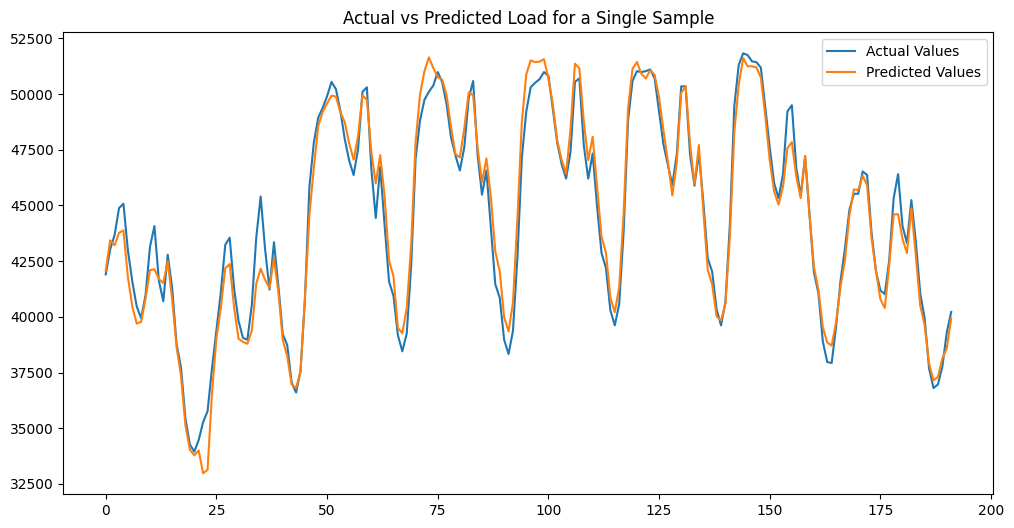

In [27]:
# Flatten the arrays before plotting
y_pred_single_flat = y_pred_single_rescaled.flatten()  # Shape (192,)
y_true_single_flat = y_true_single_rescaled.flatten()  # Shape (192,)

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_true_single_flat, label='Actual Values')  # Plot true values
plt.plot(y_pred_single_flat, label='Predicted Values')  # Plot predicted values

plt.legend()
plt.title('Actual vs Predicted Load for a Single Sample')
plt.show()
